# New York Taxi Trip Duration

Simon TURQUIER - EISI 19.4

## Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from os import path
from haversine import haversine
import warnings

warnings.simplefilter("ignore")
sns.set(color_codes=True)
%matplotlib inline

## Load Data

In [2]:
INPUT_PATH = path.join('..', 'input')
train_filepath = path.join(INPUT_PATH, 'train.csv')

df = pd.read_csv(train_filepath, index_col='id')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
test_filepath = path.join(INPUT_PATH, 'test.csv')

df_test = pd.read_csv(test_filepath, index_col='id')
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])
df_test.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
id,,,,,,,,
id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [4]:
submission_filepath = path.join(INPUT_PATH, 'sample_submission.csv')

df_submission = pd.read_csv(submission_filepath)
df_submission.head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


## Data Exploration

### Investigating each column

In [5]:
# df.info()
# df.describe()
# df.shape
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
# df['id'].describe() 
# df['id'].nunique() # unique values

# Nothing particular underneath.
# Except the trip_duration min & max
# And number of passengers min & max

# df['vendor_id'].describe()
# df['pickup_datetime'].describe()
# df['dropoff_datetime'].describe()
# df['passenger_count'].describe()
# df['pickup_longitude'].describe()
# df['pickup_latitude'].describe()
# df['dropoff_longitude'].describe()
# df['dropoff_latitude'].describe()
# df['store_and_fwd_flag'].describe()
# df['trip_duration'].describe()

### Investigating the number of passengers

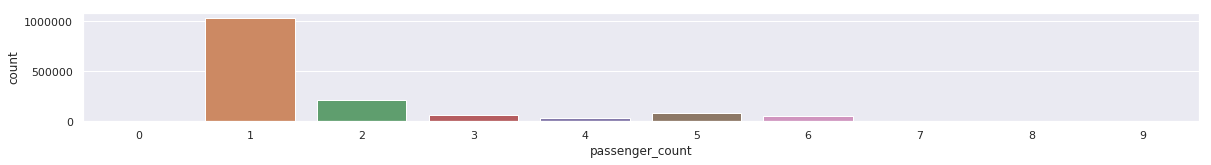

In [7]:
plt.figure(figsize=(20, 2))
sns.countplot(x='passenger_count', data=df);

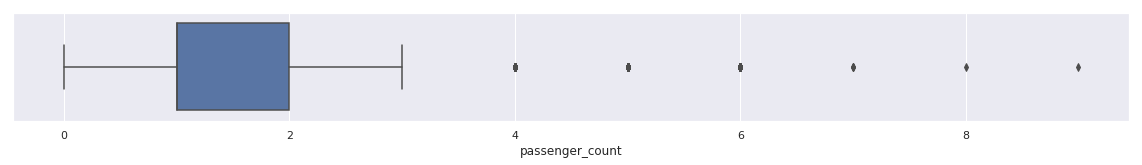

In [8]:
plt.figure(figsize=(20, 2))
passengers_number_boxplot = sns.boxplot(x=df['passenger_count'])

We can see strange data : 0 passenger in a single cab is impossible    
We will handle passenger count later when filtering DF

### Investigating trip duration

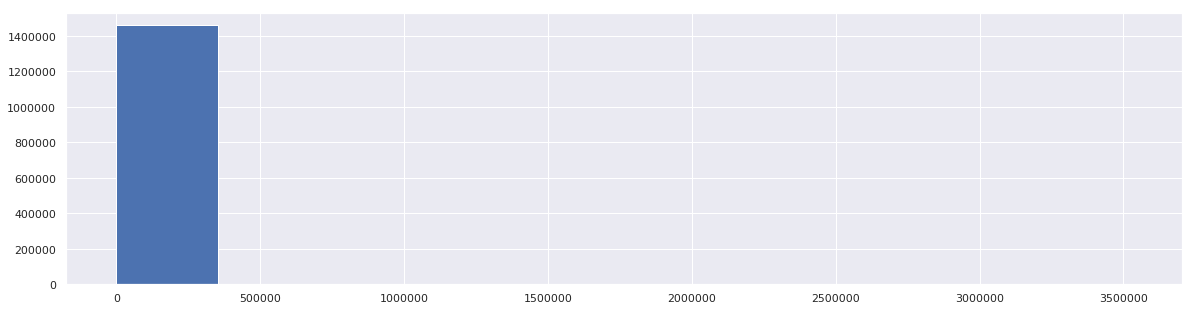

In [9]:
plt.figure(figsize=(20, 5))
df['trip_duration'].hist();

Most trips lasted for less than 2h (7 200 secs)    
Still, we can see strange data : trips for more than 7200s or trips for less than 60s  

Now, let's see how many trips for more than 2h we have

In [10]:
df.loc[df['trip_duration'] > 7200, 'trip_duration'].sum()

181905629

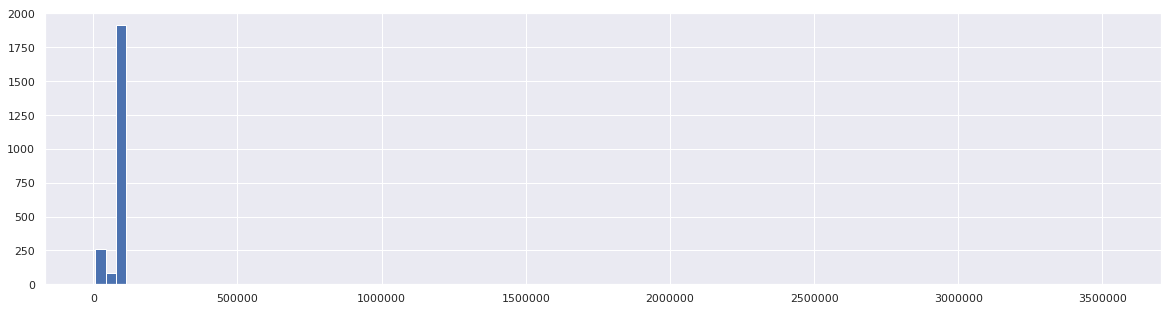

In [11]:
plt.figure(figsize=(20, 5))
df.loc[df['trip_duration'] > 7200, 'trip_duration'].hist(bins=100);

We will handle trip_duration < 7200s later when filtering DF

Now, let's see how many trips for less than 1 mn we have

In [12]:
df.loc[df['trip_duration'] < 60, 'trip_duration'].sum()

235662

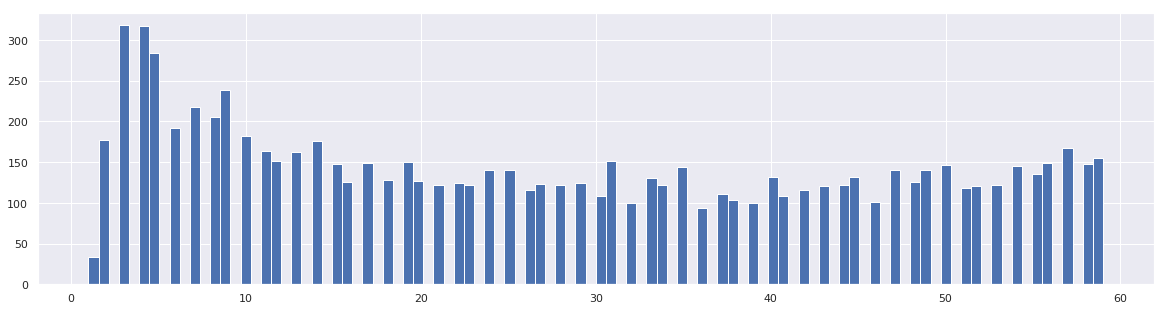

In [13]:
plt.figure(figsize=(20, 5))
df.loc[df['trip_duration'] < 60, 'trip_duration'].hist(bins=100);

We will handle trip_duration > 60s later when filtering DF

### Investigating pickup lat/lon

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


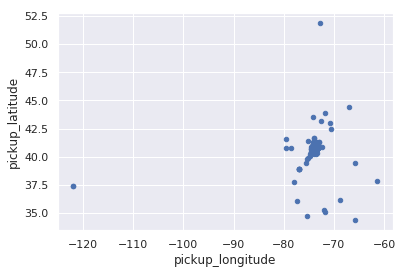

In [14]:
df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude');

The pickup lat/lon plot above shows us that most trips have been made :
* between 37.5 45 lat
* between -80 -70 lon

We will handle pickup lat/lon later when filtering DF

### Investigating dropoff lat/lon

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


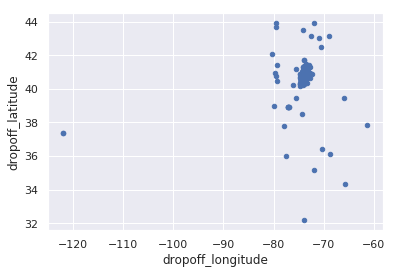

In [15]:
df.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude');

The dropoff lat/lon plot above shows us that most trips have been made :
* between 38 44 lat
* between -80 -70 lon

We will handle dropoff lat/lon later when filtering DF

## Data preprocessing

In [16]:
# haversine() calculates the distance between 2 points on earth (kms per default)
def haversine_distance(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    pickup = (pickup_lat, pickup_lon)
    dropoff = (dropoff_lat, dropoff_lon)
    
    return haversine(pickup, dropoff)

In [17]:
def preprocess(df):
    df['store_and_fwd_flag_codes'] = df['store_and_fwd_flag'].astype('category').cat.codes
    df['pickup_year'] = df['pickup_datetime'].dt.year
    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['pickup_day'] = df['pickup_datetime'].dt.day
    df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_minute'] = df['pickup_datetime'].dt.minute
    df['pickup_second'] = df['pickup_datetime'].dt.second
    df['pickup_dropoff_distance'] = df.apply(lambda x: haversine_distance(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude']), axis=1)
    
preprocess(df)
preprocess(df_test)

### Filtering data

In [24]:
# Filters we have seen previously when analysing data

trip_duration_filter = (df['trip_duration'] > 60) & (df['trip_duration'] < 7200)
passenger_count_filter = (df['passenger_count'] > 0)
pickup_filter = (df['pickup_latitude'] > 37.5) & (df['pickup_latitude'] < 45) & (df['pickup_longitude'] < -70) & (df['pickup_longitude'] > -80)
dropoff_filter = (df['dropoff_latitude'] > 38) & (df['dropoff_latitude'] < 44) & (df['dropoff_longitude'] < -70) & (df['dropoff_longitude'] > -80)

df = df[trip_duration_filter]
df = df[passenger_count_filter]
df = df[pickup_filter]
df = df[dropoff_filter]

df.shape

(1447569, 20)

## Features engineering

In [25]:
FEATURES = [
    'vendor_id',
    'pickup_year',
    'pickup_month',
    'pickup_day',
    'pickup_dayofweek',
    'pickup_weekday',
    'pickup_hour',
    'pickup_minute',
    'pickup_second',
    'passenger_count',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'store_and_fwd_flag_codes',
    'pickup_dropoff_distance'
]

TARGET = 'trip_duration'

In [26]:
def split_dataset(df, features, target):
    X = df[features]
    y = df[target]
    
    return X, y

In [ ]:
X_train, y_train = split_dataset(
    df,
    features=FEATURES,
    target=TARGET
)

X_train.shape, y_train.shape

## Modeling

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

### Cross-validation

In [ ]:
from sklearn.model_selection import cross_val_score

losses = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_log_error')
losses = [np.sqrt(-l) for l in losses]

np.mean(losses)

### Fit

In [ ]:
rf.fit(X_train, y_train)

X_test = df_test[FEATURES]

### Prediction

In [ ]:
y_test_pred = rf.predict(X_test)
y_test_pred.mean()

## Submission

In [ ]:
df_submission['trip_duration'] = y_test_pred
df_submission.head()

In [ ]:
df_submission.to_csv('submission.csv', index=False)

In [ ]:
!ls